In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim.lr_scheduler as lr_scheduler
ct = 0
np.random.seed(50)
random.seed(50)
torch.manual_seed(50)

flg = 0
dx = 20;
dy = 1
N = 100;
X = (torch.randn(dx,N));
X = torch.nn.functional.normalize(X,p=2,dim=0)     ### Input data

class relu(nn.Module): 
    def __init__(self): 
        super(relu, self).__init__() 

    def forward(self, x): 
        rl = torch.relu(x) 
        return rl

# Define the neural network 
class Net(nn.Module): 
    def __init__(self, H1): 
        super(Net, self).__init__() 
        self.fc1 = nn.Linear(dx,H1,bias=False)
        self.fc2 = nn.Linear(H1,1,bias=False)
        self.activation = relu()

    def forward(self, x): 
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x



### Defining Labels as the output of a smaller network
N_hid_gt = 2
model_gt = Net(N_hid_gt)
init_u1_gt = (torch.randn(dx,N_hid_gt));
init_u2_gt = torch.randn(N_hid_gt,1);
nm_tot = torch.sqrt(torch.linalg.matrix_norm(init_u1_gt)**2 + torch.linalg.matrix_norm(init_u2_gt)**2)
with torch.no_grad():
    model_gt.fc1.weight.data = init_u1_gt.clone().T
    model_gt.fc2.weight.data = init_u2_gt.clone().T

y = model_gt(X.T);        ## Labels

N_hid1 = 50       #### Number of hidden neurons
# Define the neural network 
model = Net(N_hid1)
learning_rate = 0.0002
num_epochs = 300000
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

init_u1 = torch.randn(dx,N_hid1);
init_u2 = torch.randn(N_hid1,1);
nm_tot = torch.sqrt(torch.linalg.matrix_norm(init_u1)**2 + torch.linalg.matrix_norm(init_u2)**2)
init_u1 = init_u1/nm_tot
init_u2 = init_u2/nm_tot
dlt = 0.00005   
U1_st = torch.zeros(N_hid1,dx,num_epochs)
U2_st = torch.zeros(1,N_hid1,num_epochs)
with torch.no_grad():
    model.fc1.weight.data = dlt*init_u1.clone().T      ##### Small initialization of weights
    model.fc2.weight.data = dlt*init_u2.clone().T

epochs = 0
dc_mt = -2
ls_st = torch.zeros(num_epochs)
while epochs < num_epochs:

    pred = model(X.T);
    loss = loss_fn(y,pred)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    ##### Storing the weights
    U1 = model.fc1.weight.data.detach()
    U2 = model.fc2.weight.data.detach()
    U1_st[:,:,epochs] = U1
    U2_st[:,:,epochs] = U2
    ls_st[epochs] = loss.item()
    if epochs%10000 == 0:
        print(loss.item())         ##### Printing loss after every 10000 epochs
    epochs = epochs+1






1.9995394945144653
1.9995394945144653
1.9995394945144653
1.9995394945144653
1.9995394945144653
1.9995393753051758
1.999537467956543
1.9995254278182983
1.9994430541992188
1.9988726377487183
1.9949429035186768
1.9682334661483765
1.802313208580017
1.1640942096710205
0.534822404384613
0.3861677050590515
0.3321549892425537
0.2929847836494446
0.27329176664352417
0.2609497010707855
0.256000280380249
0.25408628582954407
0.2532954514026642
0.2529382109642029
0.2527596652507782
0.25265806913375854
0.25258687138557434
0.2525148391723633
0.2524104714393616
0.2522210478782654


Text(193000, 0.1, '(II)')

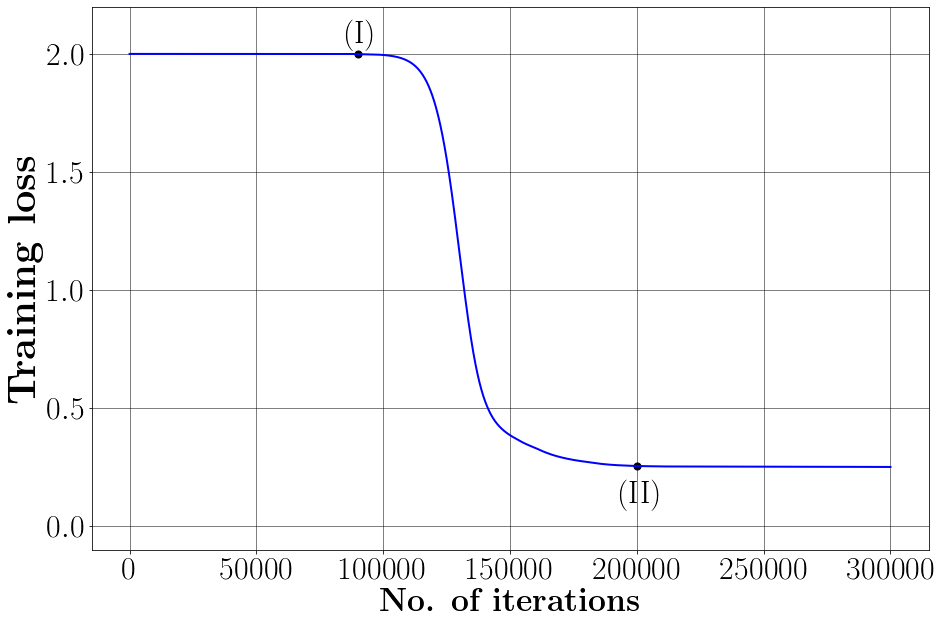

In [2]:
###### Plot of the evolution of loss with iterations

import math as m
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['text.usetex']=True
# plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 32}
matplotlib.rc('font', **font)
st_itr = 0
end_itr = 300000
stp = 10
ep1 = 90000
ep2 = 200000

fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel(r'\textbf{No. of iterations}')
ax.plot(np.arange(st_itr,end_itr),ls_st[st_itr:end_itr],color='b', linestyle='-',linewidth = 2)
ax.set_ylabel(r'\textbf{Training loss}',rotation='vertical',fontsize=40)
ax.grid(b=True, which='major', color='k', linestyle='-',linewidth = 0.5)
ax.scatter(ep1,ls_st[ep1],50,'k')
ax.scatter(ep2,ls_st[ep2],50,'k')
ax.set_ylim([-0.1,2.2])

W, H = ep1, 2.05
ax.text(W-5000, H, r'(I)')
W, H = ep2, 0.1
ax.text(W-7000, H, r'(II)')





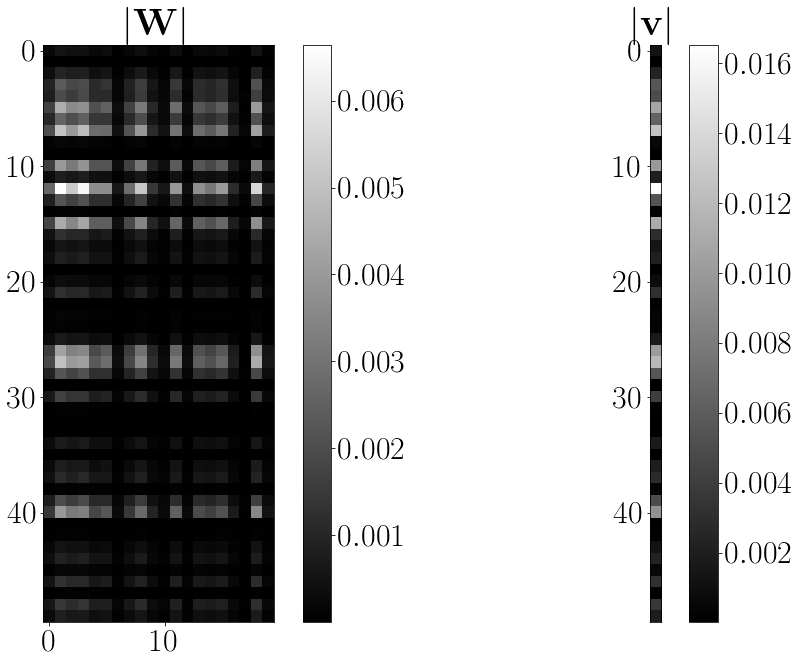

In [3]:
### Plotting weights at iteration 90000, just before escaping the origin


fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Plot the first image
im1 = axes[0].imshow(torch.abs(U1_st[:, :, 90000]), cmap='gray')
axes[0].set_title(r'$|\mathbf{W}|$')
fig.colorbar(im1, ax=axes[0])

# Plot the second image
im2 = axes[1].imshow(torch.abs(U2_st[0:1, :, 90000].T), cmap='gray')
axes[1].set_title(r'$ |\mathbf{v}|$')
axes[1].set_xticks([])  # Remove x-axis ticks for the second plot
fig.colorbar(im2, ax=axes[1])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()

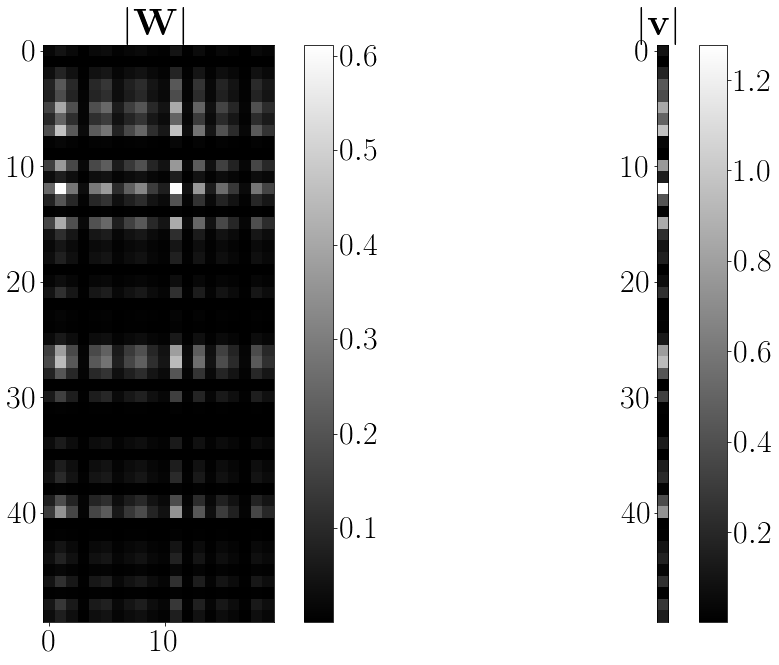

In [4]:
### Plotting weights at iteration 200000, just after reaching the saddle point

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Plot the first image
im1 = axes[0].imshow(torch.abs(U1_st[:, :, 200000]), cmap='gray')
axes[0].set_title(r'$|\mathbf{W}|$')
fig.colorbar(im1, ax=axes[0])

# Plot the second image
im2 = axes[1].imshow(torch.abs(U2_st[0:1, :, 200000].T), cmap='gray')
axes[1].set_title(r'$ |\mathbf{v}|$')
axes[1].set_xticks([])  # Remove x-axis ticks for the second plot
fig.colorbar(im2, ax=axes[1])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()